## Code 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
import math
import re
import gc
import random
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt
import numpy as np
randn = np.random.randn
from pandas import *
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rezka/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'plotting', 'test', 'random', 'unique']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def randomize_data(inps, instr, labels):
    remove_ind = np.arange(0, int(0.5 * len(inps)),1)
    add_ind = np.arange(int(0.5 * len(inps)) ,len(inps),1)
    assert len(remove_ind) == len(add_ind)
    random.shuffle(remove_ind)
    random.shuffle(add_ind)
    shuffled_index = np.array([val for pair in zip(remove_ind, add_ind) for val in pair])
    return np.array(inps)[shuffled_index].tolist(), np.array(instr)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

def randomize_data_add(inps, instr, labels):
    #remove_ind = np.arange(0, 0.5 * len(inps),1)
    add_ind = np.arange(int(0.5 * len(inps)) ,len(inps),1)
    #assert len(remove_ind) == len(add_ind)
    #random.shuffle(remove_ind)
    random.shuffle(add_ind)
    shuffled_index = np.array([val for val in add_ind])
    return np.array(inps)[shuffled_index].tolist(), np.array(instr)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

def randomize_data_remove(inps, instr, labels):
    remove_ind = np.arange(0, int(0.5 * len(inps)),1)
    #add_ind = np.arange(0.5 * len(inps) ,len(inps),1)
    #assert len(remove_ind) == len(add_ind)
    random.shuffle(remove_ind)
    #random.shuffle(add_ind)
    shuffled_index = np.array([val for val in remove_ind])
    return np.array(inps)[shuffled_index].tolist(), np.array(instr)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

In [17]:
# generate data
inps_t = []
targets_t = []
instrs_t = []
dist_ins = set()
with open("./dataset/lang_games_data_artificial_test_nvl_utter_blocks_50000.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        inp = ar[0]
        ins = ar[1]
        lab = ar[2].replace("\n","")
        inps_t.append(inp)
        targets_t.append(lab)
        instrs_t.append(ins)
        dist_ins.add(ins)
        
inps_ta, instrs_ta, targets_ta = randomize_data_add(inps_t, instrs_t, targets_t)
inps_tr, instrs_tr, targets_tr = randomize_data_remove(inps_t, instrs_t, targets_t)
inps_t, instrs_t, targets_t = randomize_data(inps_t, instrs_t, targets_t)

inps_v = []
targets_v = []
instrs_v = []
with open("./dataset/lang_games_data_artificial_valid_nvl_utter_blocks_50000.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        inp = ar[0] 
        ins = ar[1]
        lab = ar[2].replace("\n","")
        inps_v.append(inp)
        targets_v.append(lab)
        instrs_v.append(ins)
        dist_ins.add(ins)
inps_v, instrs_v, targets_v = randomize_data(inps_v, instrs_v, targets_v)

inps = []
targets = []
instrs = []
with open("./dataset/lang_games_data_artificial_train_nvl_utter_blocks_50000.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        inp = ar[0] 
        ins = ar[1]
        lab = ar[2].replace("\n","")
        inps.append(inp)
        targets.append(lab)
        instrs.append(ins)
inps, instrs, targets = randomize_data(inps, instrs, targets)

In [18]:
print(dist_ins)

{'add red to 6th tile', 'remove cyan at every tile', 'add red to leftmost tile', 'remove orange at every tile', 'add red to even tile', 'remove cyan at 3rd tile', 'remove cyan at 2nd tile', 'add brown to 3rd tile', 'add cyan to 6th tile', 'remove brown at every tile', 'remove red at leftmost tile', 'remove brown at 5th tile', 'remove orange at 6th tile', 'add orange to leftmost tile', 'remove brown at 2nd tile', 'add red to 3rd tile', 'add cyan to 1st tile', 'remove cyan at 4th tile', 'add brown to 4th tile', 'add cyan to 4th tile'}


In [48]:
dist=set()
for el in dist_ins:
    for w in wss:
        if w in el:
            dist.add(el)
print(len(list(dist)))

15


In [ ]:
#[remove, add, red, cyan, orange, brown, 1st, 2nd, 3rd, 4th, 5th, 6th, every, leftmost, even]

In [19]:
## get total character ##
block_characters = set()
for el in inps:
    els = el.split(" ")
    for e in els:
        block_characters.add(e)
#block_characters.add("SOS")
        
block_characters = sorted(list(block_characters))
n_block_letters = len(block_characters)

## get total word in utterance ##
all_words = set()
for el in instrs:
    els = el.split(" ")
    for e in els:
        all_words.add(e)
        
all_words = sorted(list(all_words))
n_words_utterance = len(all_words)

# length of the blocks configuration and utterance
len_example = len(inps[0].split(" "))
len_labels = len(targets[0].split(" "))
len_instr = len(instrs[0].split(" "))
assert len_example == len_labels

In [20]:
# turn string into list of longs
def char_tensor(string):
    string = string.split(" ")[:-1]
    tensor = torch.zeros(n_letters).long()
    char_index = block_characters.index(string)
    tensor[char_index] = 1
    return tensor

def categories_tensor(string):
    string = string.split(" ")
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = block_characters.index(letter)
        tensor[li] = letter_index
    return tensor

def seq_tensor(string):
    string = string.split(" ")
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = block_characters.index(letter)
        tensor[li] = letter_index
    return tensor

def instr_tensor(string):
    string = string.split(" ")
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = all_words.index(letter)
        tensor[li] = letter_index
    return tensor

In [21]:
def generate_batch(start_index, len_example, len_labels, len_instr, batch_size, inps, instrs, labels):
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, len_labels).long()
    ins_tensor = torch.zeros(batch_size, len_instr).long()
    for i in range(batch_size):
        inp = seq_tensor(inps[start_index+i])
        lab = categories_tensor(labels[start_index+i])
        ins = instr_tensor(instrs[start_index+i])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
        ins_tensor[i,:] = ins
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor).cuda(), Variable(ins_tensor).cuda(), Variable(lab_tensor).cuda()

In [22]:
def generate_random_batch(len_example, len_labels, len_instr, batch_size, inps, instrs, labels):
    even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    a = random.choice(even_ind, batch_size // 2)
    b = random.choice(odd_ind, batch_size // 2)
    random_index = np.concatenate([a,b])
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, len_labels).long()
    ins_tensor = torch.zeros(batch_size, len_instr).long()
    for i, ind in enumerate(random_index):
        inp = seq_tensor(inps[ind])
        lab = categories_tensor(labels[ind])
        ins = instr_tensor(instrs[start_index+i])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
        ins_tensor[i,:] = ins
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor).cuda(), Variable(ins_tensor).cuda(), Variable(lab_tensor).cuda()

In [23]:
def convert_string(texts):
    inp_tensor = torch.zeros(1, len_example).long()
    inp = seq_tensor(texts)
    inp_tensor[0,:] = inp
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor).cuda()

In [24]:
def generate_position_ids(batch_size):
    pos_tensor = torch.zeros(batch_size, len_example).long()
    for i in range(batch_size):
        pos_tensor[i] = torch.LongTensor(range(0, len_example))
    return Variable(pos_tensor).cuda()

In [25]:
# hyperparameters
n_epochs = 40
n_hidden = 64
n_layers = 1
layers_conv = 5
lr = 1e-3
clip = 5
batch_size = 100
dropout = 0.5
instr_len = 5
concat = False

print_every = 200

In [26]:
class EncoderWord(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2):
        super(EncoderWord, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        
    def forward(self, inputs, hidden, batch_size):
        # Note: we run this all at once (over the whole input sequence)
        embedded = self.embedding(inputs)
        seq_len = embedded.size(1)
        ht, hidden = self.lstm(embedded, hidden) # [batch_size, seq_len, hidden_size]
        return ht, hidden

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        c0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        return h0, c0

In [27]:
encoder = EncoderWord(n_words_utterance, n_hidden, n_layers=n_layers)
enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
encoder.cuda()

EncoderWord(
  (embedding): Embedding(20, 64)
  (lstm): LSTM(64, 64, batch_first=True)
)

In [28]:
# inp, instr, target = generate_batch(0, len_example, len_labels, len_instr, 10, inps, instrs, targets)
# hid = encoder.init_hidden(10)
# ht, hidden = encoder(instr, hid, 10)
# print(hidden[0][0].size())

In [29]:
class ConvDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_channels, output_size, max_len, kernel_size=3, n_layers=2, 
                 dropout_p=0.2, example_len=15):
        super(ConvDecoder, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.input_dropout = nn.Dropout(p=dropout_p)
        self.embed = nn.Embedding(input_size, hidden_size)
        self.position_embedding = nn.Embedding(max_len, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.len_instr = example_len
        self.len_block = max_len
        
        self.conv = nn.ModuleList([nn.Conv1d(num_channels, num_channels, kernel_size,
                                      padding=kernel_size // 2) for _ in range(n_layers)])
        # for context-attended output
        self.linear_out = nn.Linear(hidden_size*2, hidden_size)
    
    def forward(self, inputs, position_inp, batch_size, attn=False, context=None):
        # Retrieving position and word embeddings 
        position_embedding = self.position_embedding(position_inp)
        word_embedding = self.embed(inputs)
        output = None
        # for visualization #
        vis_attn = Variable(torch.zeros(self.len_block, batch_size, 1, self.len_instr)).cuda()
        
        # Applying dropout to the sum of position + word embeddings
        embedded = self.input_dropout(position_embedding + word_embedding) # [batch_size, seq_len, embed_size]
        # Transform the input to be compatible for Conv1d as follows
        # Num Batches * Length * Channel ==> Num Batches * Channel * Length
        embedded = embedded.transpose(1, 2)
        
        # Successive application of convolution layers followed by residual connection
        # and non-linearity
        cnn = embedded
        for i, layer in enumerate(self.conv):
            # layer(cnn) is the convolution operation on the input cnn after which
            # we add the original input creating a residual connection
            #if attn:
            # Applying attention to the hidden states produced by the deep convolution
            ht = cnn.transpose(1,2) # batch_size, seq_len, hidden_size
            attn = torch.bmm(ht, context.transpose(1, 2))
            #print(attn.size())
            attn = F.softmax(attn.view(-1, self.len_instr), dim=1).view(batch_size, -1, self.len_instr)

            # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
            mix = torch.bmm(attn, context)

            # concat -> (batch, out_len, 2*dim)
            combined = torch.cat((mix, ht), dim=2)
            # output -> (batch, out_len, dim)
            ht = F.tanh(self.linear_out(combined.view(-1, 2 * self.hidden_size))).view(
                batch_size, -1, self.hidden_size)
            #print(ht.size())
            vis_attn = attn
            cnn = ht.transpose(1,2)
            cnn = F.tanh(layer(cnn)+cnn)        
        out_ht = cnn.transpose(1,2)
        #print(out_ht.size())
        output = F.log_softmax(self.output(out_ht),dim=2)
        return output, vis_attn
    
#     def forward(self, inputs, hidden, batch_size, attn=False, context=None):
#         embedded = self.embed(inputs) # [batch_size, seq_len, embed_size]
#         embedded = self.input_dropout(embedded)
#         inp_embedded = embedded
#         output = None
#         # for visualization #
#         vis_attn = Variable(torch.zeros(1, batch_size, 1, self.example_len)).cuda()
        
#         if not attn:
#             ht, hidden = self.lstm(embedded, hidden) # [batch_size, seq_len, hidden_size]
#             output = F.log_softmax(self.output(ht.squeeze(1)), dim=1)
#             out_ht = ht
#         else:   
#             ### attention with mlp concat bahdanau ###
#             ht, hidden = self.lstm(embedded, hidden) # [batch_size, 1, hidden_size]
#             # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
#             # in_len is the number of blocks in initial block configuration
#             # out_len is the number of step which is 1
#             if self.concat:
#                 ht_exp = ht.expand(batch_size, self.example_len, self.hidden_size)
#                 ht_tr = ht_exp.contiguous().view(-1, self.hidden_size)

#                 # reshape encoder states to allow batchwise computation
#                 context_tr = context.contiguous().view(-1, self.hidden_size)

#                 mlp_input = torch.cat((ht_tr, context_tr), dim=1)

#                 # apply mlp and respape to get in correct form
#                 mlp_output = self.mlp(mlp_input)
#                 attn = mlp_output.view(batch_size, 1, self.example_len)
#                 attn = F.softmax(attn.view(-1, self.example_len), dim=1).view(batch_size, -1, self.example_len)

#                 # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
#                 mix = torch.bmm(attn, context)
#                 out_ht = torch.cat((mix, ht), dim=2)

#                 vis_attn[0] = attn
#             else:
#                 attn = torch.bmm(ht, context.transpose(1, 2))
#                 attn = F.softmax(attn.view(-1, self.example_len), dim=1).view(batch_size, -1, self.example_len)

#                 # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
#                 mix = torch.bmm(attn, context)

#                 # concat -> (batch, out_len, 2*dim)
#                 combined = torch.cat((mix, ht), dim=2)
#                 # output -> (batch, out_len, dim)
#                 ht = F.tanh(self.linear_out(combined.view(-1, 2 * self.hidden_size))).view(
#                 batch_size, -1, self.hidden_size)
#                 vis_attn[0] = attn
#                 out_ht = ht
                
#             output = F.log_softmax(self.output(out_ht.squeeze(1)),dim=1)
            
#         return output, ht, hidden, vis_attn

#     def init_hidden(self, batch_size):
#         h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
#         c0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
#         return h0, c0
    
#     def init_prev_ht(self, batch_size, seq_len):
#         ht = Variable(torch.zeros(batch_size, seq_len, self.hidden_size)).cuda()
#         return ht

In [30]:
# input_size, hidden_size, num_channels, output_size, max_len, kernel_size=3, n_layers=2, 
#                  dropout_p=0.2, example_len=15
decoder = ConvDecoder(n_block_letters, n_hidden, n_hidden, n_block_letters, len_example, kernel_size=3, 
                  n_layers=layers_conv, dropout_p=dropout, example_len=instr_len)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.NLLLoss()

In [31]:
decoder.cuda()

ConvDecoder(
  (input_dropout): Dropout(p=0.5)
  (embed): Embedding(6, 64)
  (position_embedding): Embedding(23, 64)
  (output): Linear(in_features=64, out_features=6)
  (conv): ModuleList(
    (0): Conv1d (64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d (64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d (64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Conv1d (64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Conv1d (64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (linear_out): Linear(in_features=128, out_features=64)
)

In [32]:
# training
def train(inp, instr, target, attn=False):
    loss = 0
    optimizer.zero_grad()
    enc_optimizer.zero_grad()
    teacher_forcing_ratio = 0.5
    encoder_hidden = encoder.init_hidden(batch_size)
    encoder_ht, encoder_hidden = encoder(instr, encoder_hidden, batch_size)
    context = encoder_ht
    hidden = encoder_hidden
    position_ids = generate_position_ids(batch_size)
    if attn:
        output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                             context=context)
        op = output.transpose(0,1) # seq_len, bs, class
        for c in range(len_example):
            loss += criterion(op[c], target[:,c])
        #loss += criterion(output.view(batch_size, -1), target[:,c])
    else:
        output, _ = decoder(inp, position_ids, batch_size)
        op = output.transpose(0,1) # seq_len, bs, class
        for c in range(len_example):
            loss += criterion(op[c], target[:,c])
    loss.backward()
    optimizer.step()
    enc_optimizer.step()

    return loss.data[0]  / len_labels

In [33]:
# batch_size = 100
# start_index = 0
# inp, instr, target = generate_batch(start_index, len_example, len_labels, len_instr, 
#                                     batch_size, inps, instrs, targets)
# print(inp.size(1))
# train(inp, instr, target, attn=True)

In [34]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [35]:
def accuracy_test_data(inps_t, instrs_t, targets_t, batch_size, attn=False):
    it = len(inps_t) / batch_size
    acc_tot = 0
    acc_tot_seq = 0
    for i in range(int(it)):
        decoder.eval()
        encoder.eval()
        start_index = i * batch_size
        inp, instr, target = generate_batch(start_index, len_example, len_labels, len_instr,
                                            batch_size, inps_t, instrs_t, targets_t)
        encoder_hidden = encoder.init_hidden(batch_size)
        encoder_ht , encoder_hidden = encoder(instr, encoder_hidden, batch_size)
        context = encoder_ht
        hidden = encoder_hidden
        position_ids = generate_position_ids(batch_size)
        if attn:
            pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                                 context=context)
            op = output.transpose(0,1) # seq_len, bs, class
            for c in range(len_labels):
                tgt_seq[c] = target[:,c]
                pred_seq[c] = op[c].max(1)[1]
                accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
                acc_tot += accuracy.data[0]
            truth = Variable(torch.ones(batch_size)).cuda() * 23
            acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size
            #print((pred_seq == tgt_seq).float().sum(dim=0))
        else:
            pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            output, _ = decoder(inp, position_ids, batch_size)
            op = output.transpose(0,1) # seq_len, bs, class
            for c in range(len_labels):
                tgt_seq[c] = target[:,c]
                pred_seq[c] = op[c].max(1)[1]
                accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
                acc_tot += accuracy.data[0]
            truth = Variable(torch.ones(batch_size)).cuda() * 23
            acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size
            #print((pred_seq == tgt_seq).float().sum(dim=0))
    return acc_tot / (it * len_labels), acc_tot_seq / it

In [21]:
accuracy_test_data(inps_t, instrs_t, targets_t, 200, attn=True)

(0.13443477959574565, 0.0)

In [36]:
def convert_to_characters(arr):
    res = ""
    for ar in arr:
        res += block_characters[int(ar)] + " "
    return res

def infer(inps_t, instrs_t, targets_t):
    batch_size = 20
    start_index = 100
    acc_tot = 0
    acc_tot_seq = 0
    decoder.eval()
    encoder.eval()
    attn=True
    inp, instr, target = generate_batch(start_index, len_example, len_labels, len_instr,
                                        batch_size, inps_t, instrs_t, targets_t)
    encoder_hidden = encoder.init_hidden(batch_size)
    encoder_ht , encoder_hidden = encoder(instr, encoder_hidden, batch_size)
    context = encoder_ht
    hidden = encoder_hidden
    position_ids = generate_position_ids(batch_size)
    if attn:
        pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
        tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
        output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                             context=context)
        op = output.transpose(0,1) # seq_len, bs, class
        for c in range(len_labels):
            tgt_seq[c] = target[:,c]
            pred_seq[c] = op[c].max(1)[1]
            accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
            acc_tot += accuracy.data[0]
        truth = Variable(torch.ones(batch_size)).cuda() * 23
        #print(pred_seq, tgt_seq)
        for c in range(batch_size):
            print(inps_t[start_index+c], instrs_t[start_index+c])
            print(convert_to_characters(tgt_seq[:,c].data))
            print(convert_to_characters(pred_seq[:,c].data))
        acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size

In [23]:
infer(inps_t, instrs_t, targets_t)

3 1 3 # 2 0 0 # 3 3 3 # 2 0 3 # 3 2 X # 3 X X remove cyan at every tile
3 1 3 # 2 0 X # 3 3 3 # 2 0 3 # 3 2 X # 3 X X 
2 2 2 2 2 2 2 # 2 2 2 2 2 2 2 2 2 2 # 2 2 2 2 
3 2 X # 3 X X # 1 1 X # 1 1 2 # 3 3 3 # 2 0 3 add brown to 3rd tile
3 2 X # 3 X X # 1 1 1 # 1 1 2 # 3 3 3 # 2 0 3 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
1 1 X # 2 0 0 # 3 2 X # 3 3 3 # 2 0 3 # 3 1 3 remove orange at 6th tile
1 1 X # 2 0 0 # 3 2 X # 3 3 3 # 2 0 3 # 3 1 X 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
3 2 X # 2 0 3 # 1 1 2 # 3 X X # 2 0 0 # 1 1 X add orange to leftmost tile
3 2 3 # 2 0 3 # 1 1 2 # 3 X X # 2 0 0 # 1 1 X 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
3 2 X # 1 1 2 # 3 3 3 # 3 X X # 2 0 0 # 3 1 3 remove red at leftmost tile
3 X X # 1 1 2 # 3 3 3 # 3 X X # 2 0 0 # 3 1 3 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
3 X X # 3 2 X # 2 0 3 # 3 1 3 # 2 0 0 # 1 1 2 add orange to leftmost tile
3 3 X # 3 2 X # 2 0 3 # 3 1 3 # 2 0 0 # 1 1 2 
2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 
1 

In [37]:
def accuracy_train_data(inps, instrs, targets, batch_size, attn=False):
    it = len(inps) / batch_size
    acc_tot = 0
    acc_tot_seq = 0
    for i in range(int(it)):
        decoder.eval()
        encoder.eval()
        start_index = i * batch_size
        inp, instr, target = generate_batch(start_index, len_example, len_labels, len_instr,
                                            batch_size, inps, instrs, targets)
        encoder_hidden = encoder.init_hidden(batch_size)
        encoder_ht , encoder_hidden = encoder(instr, encoder_hidden, batch_size)
        context = encoder_ht
        hidden = encoder_hidden
        position_ids = generate_position_ids(batch_size)
        if attn:
            pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                                 context=context)
            op = output.transpose(0,1) # seq_len, bs, class
            for c in range(len_labels):
                tgt_seq[c] = target[:,c]
                pred_seq[c] = op[c].max(1)[1]
                accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
                acc_tot += accuracy.data[0]
            truth = Variable(torch.ones(batch_size)).cuda() * 23
            acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size
            #print((pred_seq == tgt_seq).float().sum(dim=0))
        else:
            pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                                 context=context)
            op = output.transpose(0,1) # seq_len, bs, class
            for c in range(len_labels):
                tgt_seq[c] = target[:,c]
                pred_seq[c] = op[c].max(1)[1]
                accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
                acc_tot += accuracy.data[0]
            truth = Variable(torch.ones(batch_size)).cuda() * 23
            acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size
            #print((pred_seq == tgt_seq).float().sum(dim=0))
    return acc_tot / (it * len_labels), acc_tot_seq / it

In [72]:
torch.rand(1)


 0.2030
[torch.FloatTensor of size 1]

In [25]:
accuracy_train_data(inps, instrs, targets, 200, attn=True)

(0.24047307896121226, 0.0)

In [26]:
n_epochs = 100
batch_size = 50
start = time.time()
iters = 0
decoder.train(True)
encoder.train(True)
losses, accs, accs_tr = [], [], []
attn = True

writer = SummaryWriter()

cur_best = 0
for epoch in range(1, n_epochs + 1):
    start_index = 0
    steps = len(inps) / batch_size
    for i in range(int(steps)):
        start_index = i * batch_size
        inp, instr, target = generate_batch(start_index, len_example, len_labels, len_instr, 
                                     batch_size, inps, instrs, targets)
        loss = train(inp, instr, target, attn=attn)
        writer.add_scalar('data/loss', loss, iters)
        losses.append(loss)
#         if iters % print_every == 0:
#             acc, acc_seq = accuracy_test_data(inps_t, instrs_t, targets_t, batch_size, attn=attn)
#             acc_tr, acc_tr_seq = accuracy_train_data(inps, instrs, targets, batch_size, attn=attn)
#             accs.append(acc)
#             accs_tr.append(acc_tr)
#             writer.add_scalar('data/test_accuracy', acc, iters)
#             writer.add_scalar('data/train_accuracy', acc_tr, iters)
#             writer.add_scalar('data/test_seq_accuracy', acc_seq, iters)
#             writer.add_scalar('data/train_seq_accuracy', acc_tr_seq, iters)
#             print("Loss {}, Test Accuracy {}, Train Accuracy {}, Test Seq Accuracy {}, Train Seq Accuracy {}"
#                   .format(loss, acc, acc_tr, acc_seq, acc_tr_seq))
            #print("Loss {}".format(loss))
        iters += 1
    acc, acc_seq = accuracy_test_data(inps_t, instrs_t, targets_t, batch_size, attn=attn)
    acc_v, acc_v_seq = accuracy_test_data(inps_v, instrs_v, targets_v, batch_size, attn=attn)
    acc_tr, acc_tr_seq = accuracy_train_data(inps, instrs, targets, batch_size, attn=attn)
    if acc_v_seq > cur_best:
        with open('models/encoder_seq2conv_50000_nvl_utter_blocks.tar','wb') as ckpt:
             torch.save(encoder, ckpt)
        with open('models/decoder_seq2conv_50000_nvl_utter_blocks.tar','wb') as ckpt:
             torch.save(decoder, ckpt)
        cur_best = acc_v_seq
    writer.add_scalar('data/test_accuracy', acc, epoch)
    writer.add_scalar('data/train_accuracy', acc_tr, epoch)    
    writer.add_scalar('data/val_accuracy', acc_v, epoch)
    writer.add_scalar('data/test_seq_accuracy', acc_seq, epoch)
    writer.add_scalar('data/train_seq_accuracy', acc_tr_seq, epoch)
    writer.add_scalar('data/val_seq_accuracy', acc_v_seq, epoch)
    print("Loss {}, Test Accuracy {}, Train Accuracy {}, Val Accuracy {}, Test Seq Accuracy {}, Train Seq Accuracy {}, Val Seq Accuracy {}"
          .format(loss, acc, acc_tr, acc_v, acc_seq, acc_tr_seq, acc_v_seq))

writer.export_scalars_to_json("./seq2conv_50000.json")
writer.close()

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type EncoderWord. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ConvDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss 0.015053877364034239, Test Accuracy 0.9937826044533564, Train Accuracy 0.9970569313189505, Val Accuracy 0.9858043411503667, Test Seq Accuracy 0.8600000000000001, Train Seq Accuracy 0.9354761904761946, Val Seq Accuracy 0.6919999999999998
Loss 0.0017033590246801791, Test Accuracy 0.9919239075287528, Train Accuracy 0.999700827578827, Val Accuracy 0.9758695538925088, Test Seq Accuracy 0.8260000000000005, Train Seq Accuracy 0.9931190476190502, Val Seq Accuracy 0.5932499999999999
Loss 0.007395785139954608, Test Accuracy 0.9940760832765828, Train Accuracy 0.9990134557797795, Val Accuracy 0.9826630348420662, Test Seq Accuracy 0.8637499999999999, Train Seq Accuracy 0.9773333333333404, Val Seq Accuracy 0.6394999999999998
Loss 1.7581193748375643e-05, Test Accuracy 0.9926195604645688, Train Accuracy 0.9999906832109327, Val Accuracy 0.9875543422349121, Test Seq Accuracy 0.8302500000000004, Train Seq Accuracy 0.9997857142857144, Val Seq Accuracy 0.7225
Loss 3.5543027637607376e-06, Test Accuracy

Loss 3.943236468172551e-07, Test Accuracy 0.9872608615652375, Train Accuracy 1.0, Val Accuracy 0.9835325989710249, Test Seq Accuracy 0.7982500000000001, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6907499999999996
Loss 2.632970158036029e-07, Test Accuracy 0.9875434702505236, Train Accuracy 1.0, Val Accuracy 0.983510859861322, Test Seq Accuracy 0.7985, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6902499999999996
Loss 1.6461247113234687e-07, Test Accuracy 0.9875434702505236, Train Accuracy 1.0, Val Accuracy 0.983510859861322, Test Seq Accuracy 0.7985, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6902499999999996
Loss 1.0801397326323912e-07, Test Accuracy 0.9868260790148508, Train Accuracy 1.0, Val Accuracy 0.9836412946491138, Test Seq Accuracy 0.783, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6932499999999997
Loss 7.069628855274261e-08, Test Accuracy 0.9867717312082, Train Accuracy 1.0, Val Accuracy 0.9833369467569434, Test Seq Accuracy 0.781, Train Seq Accuracy 1.0, Val Seq Accuracy 0.68624

Loss 3.7859831734196e-06, Test Accuracy 0.9927391246285128, Train Accuracy 1.0, Val Accuracy 0.9780978148074254, Test Seq Accuracy 0.8602500000000004, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6334999999999997
Loss 2.0045819996005814e-06, Test Accuracy 0.9925978203182635, Train Accuracy 1.0, Val Accuracy 0.9782065105179082, Test Seq Accuracy 0.8575000000000006, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6332499999999996
Loss 1.2152057657342241e-06, Test Accuracy 0.9927282550088737, Train Accuracy 1.0, Val Accuracy 0.9782717279441978, Test Seq Accuracy 0.8597500000000006, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6334999999999996
Loss 7.742383667905612e-07, Test Accuracy 0.9926847767570744, Train Accuracy 1.0, Val Accuracy 0.9783478148605512, Test Seq Accuracy 0.8585000000000005, Train Seq Accuracy 1.0, Val Seq Accuracy 0.6339999999999997
Loss 5.042034583469934e-07, Test Accuracy 0.9927391245961189, Train Accuracy 1.0, Val Accuracy 0.9785869452292505, Test Seq Accuracy 0.8590000000000

In [27]:
with open('models/Encoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar','wb') as ckpt:
     torch.save(encoder, ckpt)
with open('models/Decoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar','wb') as ckpt:
     torch.save(decoder, ckpt)

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type EncoderWord. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ConvDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [38]:
torch.nn.Module.dump_patches = True
encoder = torch.load('models/Decoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar').cuda()
decoder = torch.load('models/Encoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar').cuda()

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. Saved a reverse patch to Embedding.patch. Run `patch -p0 < Embedding.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. Saved a reverse patch to LSTM.patch. Run `patch -p0 < LSTM.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. Saved a reverse patch to Embedding.patch. Run `patch -p0 < Embedding.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceC

In [34]:
torch.save(decoder.state_dict(), 'models/Params_Decoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar')
torch.save(encoder.state_dict(), 'models/Params_Encoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar')

In [73]:
decoder.load_state_dict(torch.load('models/Params_Decoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar'))
encoder.load_state_dict(torch.load('models/Params_Encoder_Seq2Conv_50000_nvl_utter_blocks_hid64_layer1_drop0.5_dot.tar'))

In [24]:
accuracy_test_data(inps_t, instrs_t, targets_t, batch_size, attn=True)

(0.9951630403166232, 0.8887500000000002)

In [28]:
accuracy_test_data(inps_v, instrs_v, targets_v, batch_size, attn=True)

(1.0, 1.0)

## Part 2 Experiment

In [39]:
import copy

In [40]:
def get_mutated_data(inps, color):
    res = []
    for a in inps:
        cnt = 0
        for col in color:
            if col in a:
                cnt += 1
        #if cnt == len(color):
        if cnt > 0:
            res.append(a)
    return res

In [41]:
wss = ["add", "red", "orange", "1st", "3rd", "5th", "even"]
wsr = ["et", "roze", "oranje", "1", "3", "5", "ev"]
color = wss

inpss = []
with open("./dataset/lang_games_data_artificial_valid_nvl_utter_blocks_50000.txt", "r") as f:
    for line in f:
        inpss.append(line)
inpss = get_mutated_data(inpss, color)

inps_m = []
targets_m = []
instrs_m = []

inpsss = random.choice(inpss, 1)
for elem in inpsss:
    ar = elem.split("\t")
    inp = ar[0]
    ins = ar[1]
    lab = ar[2].replace("\n","")
    inps_m.append(inp)
    targets_m.append(lab)
    instrs_m.append(ins)
    
inps_rst = []
targets_rst = []
instrs_rst = []

inpsss_rest = [i for i in inpss if not i in inpsss]
for elem in inpsss_rest:
    ar = elem.split("\t")
    inp = ar[0]
    ins = ar[1]
    lab = ar[2].replace("\n","")
    inps_rst.append(inp)
    targets_rst.append(lab)
    instrs_rst.append(ins)

inpss = []
with open("./dataset/lang_games_data_artificial_test_nvl_utter_blocks_50000.txt", "r") as f:
    for line in f:
        inpss.append(line)
inpss = get_mutated_data(inpss, color)

inps_mt = []
targets_mt = []
instrs_mt = []
for elem in inpss:
    ar = elem.split("\t")
    inp = ar[0]
    ins = ar[1]
    lab = ar[2].replace("\n","")
    inps_mt.append(inp)
    targets_mt.append(lab)
    instrs_mt.append(ins)

In [42]:
inps_new = inps_m + inps_rst
instrs_new = instrs_m + instrs_rst
targets_new = targets_m + targets_rst

In [44]:
print(len(inps_new) + len(inps_mt))

5984


In [57]:
print(instrs_new[:10])

['remove cyan at 4th tile', 'remove orange at every tile', 'remove brown at every tile', 'remove cyan at 2nd tile', 'remove cyan at 4th tile', 'remove orange at every tile', 'remove orange at every tile', 'remove brown at every tile', 'remove orange at every tile', 'remove brown at every tile']


In [58]:
accuracy_test_data(inps_mt, instrs_mt, targets_mt, 1, attn=True)

(0.9918774869492206, 0.8131821998320738)

In [59]:
accuracy_test_data(inps_new, instrs_new, targets_new, 1, attn=True)

(1.0, 1.0)

In [28]:
def mutate_instruction(sentences, words, words_to_replace):
    sentences_mutate = []
    for sentence in sentences:
        sent = sentence
        for word, word_to_replace in zip(words, words_to_replace):
            sent = sent.replace(word, word_to_replace)
        sentences_mutate.append(sent)
    return sentences_mutate

In [30]:
all_words_ext = []
all_words_ext.append(wsr)

all_words_ext = sorted(list(all_words_ext))
n_words_ext = len(all_words_ext)

all_words_comb = copy.deepcopy(all_words)
all_words_comb.append(wsr)

n_words_comb = len(all_words_comb)

In [31]:
def instr_tensor_ext(string):
    string = string.split(" ")
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = all_words_comb.index(letter)
        tensor[li] = letter_index
    return tensor

In [32]:
def generate_batch_ext(start_index, len_example, len_labels, len_instr, batch_size, inps, instrs, labels):
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, len_labels).long()
    ins_tensor = torch.zeros(batch_size, len_instr).long()
    for i in range(batch_size):
        inp = seq_tensor(inps[start_index+i])
        lab = categories_tensor(labels[start_index+i])
        ins = instr_tensor_ext(instrs[start_index+i])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
        ins_tensor[i,:] = ins
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor).cuda(), Variable(ins_tensor).cuda(), Variable(lab_tensor).cuda()

In [33]:
class EncoderExtended(nn.Module):
    def __init__(self, input_size, ext_input_size, hidden_size, n_layers=2):
        super(EncoderExtended, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding_ext = nn.Embedding(ext_input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        
    def forward(self, inputs, hidden, batch_size, new_emb):
        # Note: we run this all at once (over the whole input sequence)
        if new_emb:
            embedded = self.embedding_ext(inputs) # [1, 1, hidden_size]
            alpha_w = F.softmax(torch.mm(embedded.squeeze(1), self.embedding.weight.transpose(0,1)),dim=1).contiguous() # [1, n_words_utterance]
            embedded = 0.3 * embedded + 0.7 * torch.mm(alpha_w, self.embedding.weight).unsqueeze(0) # [1, hidden_size]
        else:
            embedded = self.embedding(inputs)
        ht, hidden = self.lstm(embedded, hidden) # [batch_size, seq_len, hidden_size]
        alph = 0
        if new_emb:
            alph = alpha_w
        return ht, hidden, alph

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        c0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        return h0, c0

In [34]:
enc_ext = EncoderExtended(n_words_utterance, n_words_ext, 64, n_layers=1)
enc_ext.cuda()

EncoderExtended(
  (embedding): Embedding(20, 64)
  (embedding_ext): Embedding(1, 64)
  (lstm): LSTM(64, 64, batch_first=True)
)

In [35]:
# si = 0
# inp_m, instr_m, target_m = generate_batch_ext(si, len_example, len_labels, len_instr, 1, inps_m, instrs_m, targets_m)
# hid = enc_ext.init_hidden(1)
# cntxt = Variable(torch.zeros(len_instr, 1, 1, n_hidden)).cuda()
# for c in range(len_instr):
#     if instr_m[:,c].data[0] < n_words_utterance:
#         ht, hid = enc_ext(instr_m[:,c].unsqueeze(1), hid, 1, False)
#     else:
#         ht, hid = enc_ext(instr_m[:,c].unsqueeze(1) % 20, hid, 1, True)
#     cntxt[c] = ht.contiguous()
# cntxt = cntxt.squeeze(1).transpose(0,1)

In [36]:
# load parameters from trained model
params1 = encoder.named_parameters()
params2 = enc_ext.named_parameters()

dict_params2 = dict(params2)

for name1, param1 in params1:
    if name1 in dict_params2:
        dict_params2[name1].data.copy_(param1.data)
        
# freeze all weights except the connected one
for name, params in enc_ext.named_parameters():
    if name != "embedding_ext.weight":
        params.requires_grad = False
        
enc_ext_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, enc_ext.parameters()), lr=1e-3)

In [37]:
for name, params in enc_ext.named_parameters():
    if name == "embedding_ext.weight":
        print(name, params)

embedding_ext.weight Parameter containing:

Columns 0 to 9 
 0.4950 -0.0409 -2.7921  1.6280  1.8966  0.8831 -1.5419 -0.5645 -0.1274  0.7138

Columns 10 to 19 
 0.9740  1.3057 -1.4484  0.1319  0.1255 -0.7219 -0.7204 -1.5245 -0.3485 -1.9738

Columns 20 to 29 
-1.4126  0.3942 -0.4011  0.3479  0.3589 -0.4242  0.8558  1.2909  0.2071  2.3702

Columns 30 to 39 
 0.1726  0.3056  0.6090 -0.2362  0.7549 -0.0403 -0.1209  0.3639 -0.5272 -0.5664

Columns 40 to 49 
-0.3245  0.2536 -0.4154 -0.1279  2.0042 -0.0961 -0.8446 -1.4666  0.9302 -0.2920

Columns 50 to 59 
 2.3861 -0.3729  1.7409  0.1759 -0.0751 -0.6022  1.7686  0.2296 -1.9346  0.2579

Columns 60 to 63 
 0.4148  0.0434 -0.6911  0.0130
[torch.cuda.FloatTensor of size 1x64 (GPU 0)]



In [264]:
instrs_m = mutate_instruction(instrs_m, wss, wsr)
instrs_mt = mutate_instruction(instrs_mt, wss, wsr)
instrs_rst = mutate_instruction(instrs_rst, wss, wsr)

In [ ]:
def random_search():
    attn=True
    batch_size=1
    cur_best = 0
    saved_params = dict_params2["embedding_ext.weight"]
    for i in range(1000):
        c
        acc, acc_seq = accuracy_test_data_ext(inps_mt, instrs_mt, targets_mt, batch_size, attn=attn)
        acc_rst, acc_rst_seq = accuracy_test_data_ext(inps_rst, instrs_rst, targets_rst, batch_size, attn=attn)
        if acc_seq > cur_best:
            cur_best = acc_seq
            saved_params = dict_params2["embedding_ext.weight"]
            print(i, acc_seq, acc_rst_seq)
            if acc_seq == 1.0:
                break
        else:
            print(i, acc_seq, acc_rst_seq)
    return saved_params
saved_params = random_search()

In [95]:
print(dict_params2["embedding.weight"][15])

Variable containing:
-0.1490
 3.6359
 0.2455
-0.9514
 0.5914
-1.1509
-1.2822
 1.6259
 1.5317
 1.5286
-0.7074
 0.3230
-0.4524
 0.5571
 0.4833
-0.1936
 0.8293
-0.3979
-0.7768
 0.7105
 0.8169
-0.1841
 1.3799
-0.0886
 0.8845
-0.2790
-0.6195
 0.4044
 1.0286
-0.1663
 0.7555
-0.8804
-0.8712
-1.7720
 0.8139
-0.7373
 1.2371
-0.7260
-1.1261
 0.0416
 0.2822
 0.1862
-0.7144
 1.5880
-0.9536
-0.6163
 1.0008
-1.6744
-0.9191
 1.1671
 0.7302
-1.1990
-0.4048
 0.6357
-0.0544
-0.7590
-0.2266
 0.7096
-0.0285
 1.7030
 0.7983
 1.1275
 0.0613
 1.0947
[torch.cuda.FloatTensor of size 64 (GPU 0)]



In [110]:
print(saved_params[0])

Variable containing:
 1.2546
-1.6789
-0.9043
 0.6247
 1.9500
-0.0688
-2.0882
-0.3522
-1.4150
 0.2225
-0.4135
-0.6879
 0.1510
 0.2397
 2.0495
-0.9066
 0.6581
 0.3126
 0.9969
 0.3044
 1.2554
 0.1249
-0.2947
-1.1226
 0.3517
 1.3698
-0.6399
-1.3569
 0.5946
-0.7505
-1.0239
-1.3207
 1.5025
 0.0004
-1.0920
-1.0694
-0.3285
 0.9867
 0.8493
 0.7228
-1.5289
 1.4087
 0.6339
-1.1798
 2.1724
 0.2657
-0.9867
 0.1668
-0.8257
-0.4330
-1.0945
 0.7771
-0.2371
-1.4405
 1.5853
 1.4464
 1.0117
 1.3034
-2.4712
 1.0102
-1.0060
-0.8578
 0.4331
 0.7396
[torch.cuda.FloatTensor of size 64 (GPU 0)]



In [94]:
print(F.cosine_similarity(dict_params2["embedding.weight"][15].unsqueeze(0), saved_params))

Variable containing:
 0.2032
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [38]:
# training
def train_ext(inp, instr, target, attn=False):
    loss = 0
    enc_ext_optimizer.zero_grad()
    hid = enc_ext.init_hidden(1)
    cntxt = Variable(torch.zeros(len_instr, 1, 1, n_hidden)).cuda()
    for c in range(len_instr):
        if instr[:,c].data[0] < n_words_utterance:
            ht, hid, _ = enc_ext(instr[:,c].unsqueeze(1), hid, 1, False)
        else:
            ht, hid, _ = enc_ext(instr[:,c].unsqueeze(1) % 20, hid, 1, True)
        cntxt[c] = ht.contiguous()
    cntxt = cntxt.squeeze(1).transpose(0,1)
    context = cntxt
    hidden = hid
    position_ids = generate_position_ids(batch_size)
    if attn:
        output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                             context=context)
        op = output.transpose(0,1) # seq_len, bs, class
        for c in range(len_example):
            loss += criterion(op[c], target[:,c])
        #loss += criterion(output.view(batch_size, -1), target[:,c])
    else:
        output, _ = decoder(inp, position_ids, batch_size)
        op = output.transpose(0,1) # seq_len, bs, class
        for c in range(len_example):
            loss += criterion(op[c], target[:,c])
    loss.backward()
    enc_ext_optimizer.step()

    return loss.data[0]  / len_labels

In [39]:
# batch_size = 1
# start_index = 7
# inp, instr, target = generate_batch_ext(start_index, len_example, len_labels, len_instr, 
#                                     batch_size, inps, instrs, targets)
# train_ext(inp, instr, target, attn=True)

In [40]:
def accuracy_test_data_ext(inps_mt, instrs_mt, targets_mt, batch_size, attn=False):
    it = len(inps_mt) / batch_size
    acc_tot = 0
    acc_tot_seq = 0
    for i in range(int(it)):
        decoder.eval()
        enc_ext.eval()
        start_index = i * batch_size
        inp, instr, target = generate_batch_ext(start_index, len_example, len_labels, len_instr,
                                            batch_size, inps_mt, instrs_mt, targets_mt)
        hid = enc_ext.init_hidden(batch_size)
        cntxt = Variable(torch.zeros(len_instr, batch_size, 1, n_hidden)).cuda()
        for c in range(len_instr):
            if instr[:,c].data[0] < n_words_utterance:
                ht, hid, _ = enc_ext(instr[:,c].unsqueeze(1), hid, batch_size, False)
            else:
                ht, hid, _ = enc_ext(instr[:,c].unsqueeze(1) % 20, hid, batch_size, True)
            cntxt[c] = ht.contiguous()
        cntxt = cntxt.squeeze(2).transpose(0,1).contiguous()
        context = cntxt
        #ht, hid = enc_ext(instr, hid, batch_size, False)
        #context = ht
        position_ids = generate_position_ids(batch_size)
        if attn:
            pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            output, vis_attn = decoder(inp, position_ids, batch_size, attn=True, 
                                 context=context)
            op = output.transpose(0,1) # seq_len, bs, class
            for c in range(len_labels):
                tgt_seq[c] = target[:,c]
                pred_seq[c] = op[c].max(1)[1]
                accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
                acc_tot += accuracy.data[0]
            truth = Variable(torch.ones(batch_size)).cuda() * 23
            acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size
            #print((pred_seq == tgt_seq).float().sum(dim=0))
        else:
            pred_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            tgt_seq = Variable(torch.zeros(len_labels, batch_size)).cuda()
            output, _ = decoder(inp, position_ids, batch_size)
            op = output.transpose(0,1) # seq_len, bs, class
            for c in range(len_labels):
                tgt_seq[c] = target[:,c]
                pred_seq[c] = op[c].max(1)[1]
                accuracy = (op[c].max(1)[1] == target[:,c]).float().sum().float() / batch_size
                acc_tot += accuracy.data[0]
            truth = Variable(torch.ones(batch_size)).cuda() * 23
            acc_tot_seq += ((pred_seq == tgt_seq).float().sum(dim=0) == truth).float().sum().data[0] / batch_size
            #print((pred_seq == tgt_seq).float().sum(dim=0))
    return acc_tot / (it * len_labels), acc_tot_seq / it

In [298]:
accuracy_test_data_ext(inps_mt, instrs_mt, targets_mt, 2, attn=True)

(1.0, 1.0)

In [319]:
instrs_m = mutate_instruction(instrs_m, wss, wsr)
instrs_mt = mutate_instruction(instrs_mt, wss, wsr)
instrs_rst = mutate_instruction(instrs_rst, wss, wsr)

In [320]:
accuracy_test_data_ext(inps_mt, instrs_mt, targets_mt, 1, attn=True)

(0.9578487670704049, 0.08712541620421754)

In [53]:
accuracy_test_data_ext(inps_rst, instrs_rst, targets_rst, 1, attn=True)

(1.0, 1.0)

In [321]:
n_epochs = 100
batch_size = 1
start = time.time()
iters = 0
enc_ext.train(True)
attn = True
print_every = 100

cur_best = 0
for epoch in range(1, n_epochs + 1):
    start_index = 0
    steps = len(inps_m) / batch_size
    for i in range(int(steps)):
        start_index = i * batch_size
        inp, instr, target = generate_batch_ext(start_index, len_example, len_labels, len_instr, 
                                     batch_size, inps_m, instrs_m, targets_m)
        loss = train_ext(inp, instr, target, attn=attn)
        iters += 1
        #print(F.cosine_similarity(dict_params2["embedding.weight"][15].unsqueeze(0), dict_params2["embedding_ext.weight"]))
        #if i % print_every == 0 and i != 0:
    acc, acc_seq = accuracy_test_data_ext(inps_mt, instrs_mt, targets_mt, batch_size, attn=attn)
    #acc_rst, acc_seq_rst = accuracy_test_data_ext(inps_rst, instrs_rst, targets_rst, batch_size, attn=attn)
#     if acc_v_seq > cur_best:
#         with open('models/encoder_ext_seq2conv_50000_nvl_utter_blocks.tar','wb') as ckpt:
#              torch.save(encoder, ckpt)
#         cur_best = acc_v_seq
    #print(F.cosine_similarity(dict_params2["embedding.weight"][15].unsqueeze(0), dict_params2["embedding_ext.weight"]).data[0])
    print("Loss {}, Test Accuracy {}, Test Seq Accuracy {}"
          .format(loss, acc, acc_seq))

Loss 0.6694634893666143, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6692920353101648, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6691209129665209, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6689495418382727, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6687781707100247, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6686065507971722, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6684352211330248, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6682634768278702, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6680917739868164, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6679197808970576, Test Accuracy 0.9578487670704049, Test Seq Accuracy 0.08712541620421754
Loss 0.6677479951278024, Test 

Loss 0.6536423641702404, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6534352509871774, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6532275158426036, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6530191172724185, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6528097235638163, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6525999981424083, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6523896507594896, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.652178432630456, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.651966260827106, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.651753508526346, Test Accuracy 0.9592481783525552, Test Seq Accuracy 0.1193118756936737
Loss 0.6515402586563773, Test Accuracy 0.95

In [322]:
accuracy_test_data_ext(inps_m, instrs_m, targets_m, 1, attn=True)

(0.9565217391304348, 0.0)

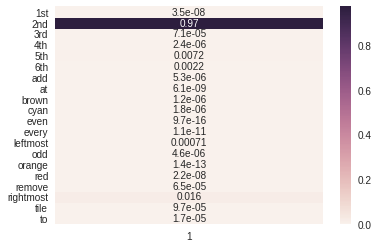

In [323]:
batch_size = 1
start_index = 0
inp, instr, target = generate_batch_ext(start_index, len_example, len_labels, len_instr, 
                                    batch_size, inps_m, instrs_m, targets_m)
hid = enc_ext.init_hidden(batch_size)
for c in range(len_instr):
    if instr[:,c].data[0] < n_words_utterance:
        ht, hid, _ = enc_ext(instr[:,c].unsqueeze(1), hid, batch_size, False)
    else:
        ht, hid, attn_alph = enc_ext(instr[:,c].unsqueeze(1) % 20, hid, batch_size, True)
        cols_alph = ["1"]
        index_alph = [j for j in all_words]
        df = DataFrame(list(attn_alph.data[0]), index=index_alph, columns=cols_alph)
        sns.heatmap(df, annot=True)

## Visualizing Attention Mask

In [44]:
def map_index(idx):
    # 0 - 0, 1 - 4, 2 - 8, 3 - 12, 4 - 16
    return idx * 4

def map_thres(idx):
    if idx == 0:
        return 0.0
    elif idx == 1:
        return 0.0
    elif idx==2:
        return 0.5

# counting correctly attended weights #
batch_size = 1
attn=True
ponder=True
pool=True
it = len(inps_to) / batch_size
#it = 5 / batch_size
ttt, ttf, tft, tff, ftt, ftf, fft, fff = 0, 0, 0, 0, 0, 0, 0, 0
ttts, ttfs, tfts, tffs, ftts, ftfs, ffts, fffs = [], [], [], [], [], [], [], []
failed_set = []
attn_avg_tctp = []
attn_avg_tcfp = []
attn_avg_fctp = []
attn_avg_fcfp = []
for j in range(int(it)):
    # pool
    pool_hidden = Variable(torch.zeros(len_example - grammar_len, batch_size, 1
                                           , n_hidden)).cuda()
    start_index = j * batch_size
    ### check where is the index of k-factors ###
    grammar, target_str = inps_to[start_index].split("$")
    kfs = grammar.split("#")
    idxs_check = []
    for k, kfs in enumerate(kfs):
        if kfs in target_str:
            start_kf = map_index(k)
            start_ts = target_str.find(kfs)
            idxs_check.append((start_kf, start_ts))
    
    ### gather the attention mask ###
    hidden = rnn.init_hidden(batch_size)
    inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps_to, labels_to)
    attn_vals = []
    prediction_at_step = []
    if attn:
        #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
        output, ht, hidden, vis_attn = rnn(inp_t[:,:20], hidden, batch_size)
    #         for j in range(ht.size(1)):
    #             if j not in [3,7,11,15,19]:
    #                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
    #                 i += 1
        grammar_contexts = ht
        #print(grammar_contexts)
        ht = rnn.init_prev_ht(batch_size, 1)
        for c in range(len_example - 20):
            attn_val = []
            #print(ht)
            if ponder:
                output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, prev_ht=ht, ponder=True)
                for i, elem in enumerate(vis_attn[3].squeeze().data):
                    attn_val.append(elem)
            else:
                output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, prev_ht=ht, ponder=False)
                for i, elem in enumerate(vis_attn[0].squeeze().data):
                    attn_val.append(elem)
            pool_hidden[c] = ht
            attn_vals.append(attn_val)
            prediction_at_step.append(list(F.softmax(rnn.output(ht.squeeze(1)),dim=1).data[0]))
        # pool
        if pool:
            logits, _ = torch.max(pool_hidden, 0)
            cls = rnn.output(logits.squeeze(1))
        else:
            cls = output
        cls = F.softmax(cls, dim=1)
        #print(list(cls.data))
        
        ### define hypothesis ###
        correct_attended = False
        predicted_correct = False
        hm_times = 0
        hm_cor = False
        put_ca = False
        put_pc = False
        attn_avg = []
        attn_avg_ext = []
        final_prediction = np.argmax(cls.data) == 0
        for idx_check in idxs_check:
            # 0 : index of k factors, 1 : index of target string
            #print(idx_check)
            hm_times = 0
            hm_cor = False
            # a is number of step
            for a in range(3):
                if a == 2 and np.argmax(prediction_at_step[idx_check[1]+a]) == 0:
                    predicted_correct = True
                    put_pc = True
                # b is a number of grammar
                for b in range(3):
                    attn_avg.append(attn_vals[idx_check[1]+a][idx_check[0]+b])
                    if attn_vals[idx_check[1]+a][idx_check[0]+b] > map_thres(a):
                        hm_cor = True
                if hm_cor:
                    hm_times += 1
                hm_cor = False
            if hm_times == 3:
                correct_attended = True
                put_ca = True
            for a in range(3,6):
                for b in range(0,3):
                    if idx_check[1] + a <= 19:
                        attn_avg.append(attn_vals[idx_check[1]+a][idx_check[0]+b])
                    else:
                        attn_avg.append(0.0)
            if final_prediction and put_pc:
                attn_avg_tctp.append(attn_avg)
            elif final_prediction and not put_pc:
                attn_avg_tcfp.append(attn_avg)
            elif not final_prediction and put_pc:
                attn_avg_fctp.append(attn_avg)
            elif not final_prediction and not put_pc:
                attn_avg_fcfp.append(attn_avg)
            put_ca = False
            put_pc = False
            attn_avg = []
        #print("Correctly Attended to Corresponding K-Factor {}".format(str(correct_attended)))
        #print("Predicted Correct when Attending to K-Factor {}".format(str(predicted_correct)))
        #print("Final Prediction {}".format(str(final_prediction)))
        if correct_attended and predicted_correct and final_prediction:
            ttt += 1
        elif correct_attended and predicted_correct and not final_prediction:
            ttf += 1
        elif correct_attended and not predicted_correct and final_prediction:
            tft += 1
        elif correct_attended and not predicted_correct and not final_prediction:
            tff += 1
        elif not correct_attended and predicted_correct and final_prediction:
            ftt += 1
        elif not correct_attended and predicted_correct and not final_prediction:
            ftf += 1
        elif not correct_attended and not predicted_correct and final_prediction:
            fft += 1
        elif not correct_attended and not predicted_correct and not final_prediction:
            fff += 1
        if not final_prediction:
            failed_set.append(inps_to[start_index])
            
    else:
        output, ht, hidden = rnn(inp, hidden, batch_size)
        cls = output[:,-1,:].contiguous()
        cls = F.softmax(cls, dim=1) 
    
### visualizing ###
#     ts = inps_to[start_index]
#     av = np.transpose(attn_vals)
#     idx = Index(list(ts[:20]))
#     df = DataFrame(av, index=idx, columns=list(ts[20:]))
#     vals = np.around(df.values,4)
#     normal = plt.Normalize(vals.min()-1, vals.max()+1)

#     fig = plt.figure(figsize=(15,8))
#     ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

#     tab1=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
#                         colWidths = [0.05]*vals.shape[1], loc='bottom', 
#                         cellColours=plt.cm.hot(normal(vals)))

#     idx = Index(["0", "1"])
#     df = DataFrame(np.transpose(prediction_at_step), index=idx, columns=list(ts[20:]))
#     vals = np.around(df.values,4)
#     normal = plt.Normalize(vals.min()-1, vals.max()+1)

#     fig = plt.figure(figsize=(15,8))
#     ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

#     tab2=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
#                         colWidths = [0.05]*vals.shape[1], loc='top', 
#                         cellColours=plt.cm.hot(normal(vals)))

In [45]:
print(len(attn_avg_tctp), len(attn_avg_tcfp), len(attn_avg_fctp), len(attn_avg_fcfp))

3285 204 612 551


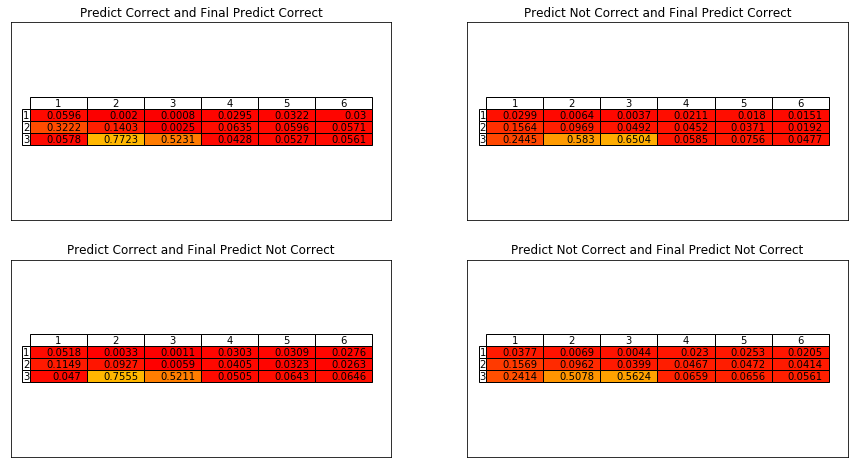

In [46]:
attn_1 = np.array(attn_avg_tctp)
attn_1_n = np.mean(attn_1[:,:9], axis=0).reshape(3,3)
attn_1_ext = np.mean(attn_1[:,9:], axis=0).reshape(3,3)
attn_2 = np.array(attn_avg_tcfp)
attn_2_n = np.mean(attn_2[:,:9], axis=0).reshape(3,3)
attn_2_ext = np.mean(attn_2[:,9:], axis=0).reshape(3,3)
attn_3 = np.array(attn_avg_fctp)
attn_3_n = np.mean(attn_3[:,:9], axis=0).reshape(3,3)
attn_3_ext = np.mean(attn_3[:,9:], axis=0).reshape(3,3)
attn_4 = np.array(attn_avg_fcfp)
attn_4_n = np.mean(attn_4[:,:9], axis=0).reshape(3,3)
attn_4_ext = np.mean(attn_4[:,9:], axis=0).reshape(3,3)

idx = Index([1,2,3])
df = DataFrame(np.concatenate((np.transpose(attn_1_n),np.transpose(attn_1_ext)),axis=1), index=idx, 
               columns=[1,2,3,4,5,6])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(221, frameon=True, xticks=[], yticks=[], title="Predict Correct and Final Predict Correct")
tab1=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))

idx = Index([1,2,3])
df = DataFrame(np.concatenate((np.transpose(attn_2_n),np.transpose(attn_2_ext)),axis=1), index=idx, 
               columns=[1,2,3,4,5,6])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

ax = fig.add_subplot(222, frameon=True, xticks=[], yticks=[], title="Predict Not Correct and Final Predict Correct")
tab2=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))

idx = Index([1,2,3])
df = DataFrame(np.concatenate((np.transpose(attn_3_n),np.transpose(attn_3_ext)),axis=1), index=idx, 
               columns=[1,2,3,4,5,6])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

ax = fig.add_subplot(223, frameon=True, xticks=[], yticks=[], title="Predict Correct and Final Predict Not Correct")
tab3=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))

idx = Index([1,2,3])
df = DataFrame(np.concatenate((np.transpose(attn_4_n),np.transpose(attn_4_ext)),axis=1), index=idx, 
               columns=[1,2,3,4,5,6])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

ax = fig.add_subplot(224, frameon=True, xticks=[], yticks=[], title="Predict Not Correct and Final Predict Not Correct")
tab4=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))

In [18]:
actdo = accuracy_test_data(inps_to, labels_to, attn=True, ponder=True)
actde = accuracy_test_data(inps_te, labels_te, attn=True, ponder=True)
actd = accuracy_test_data(inps_t, labels_t, attn=True, ponder=True)

In [53]:
print("Final Test Accuracy : {}".format(str(actd)))
print("Final Test Accuracy (Case of Reject Language / K-Factor Present) : {}".format(str(actdo)))
print("Final Test Accuracy (Case of Accept Language / K-Factor not Present) : {}".format(str(actde)))
print("### Analysis on Case of Reject Language ###")
print("Attend Correctly, Predict Correctly while Attend, Correct Final Prediction : {}".format(str(float(ttt) / len(inps_to))))
print("Attend Correctly, Predict Correctly while Attend, Wrong Final Prediction : {}".format(str(float(ttf) / len(inps_to))))
print("Attend Correctly, Predict Wrongly while Attend, Correct Final Prediction : {}".format(str(float(tft) / len(inps_to))))
print("Attend Correctly, Predict Wrongly while Attend, Wrong Final Prediction : {}".format(str(float(tff) / len(inps_to))))
print("Attend Wrongly, Predict Correctly while Attend, Correct Final Prediction : {}".format(str(float(ftt) / len(inps_to))))
print("Attend Wrongly, Predict Correctly while Attend, Wrong Final Prediction : {}".format(str(float(ftf) / len(inps_to))))
print("Attend Wrongly, Predict Wrongly while Attend, Correct Final Prediction : {}".format(str(float(fft) / len(inps_to))))
print("Attend Wrongly, Predict Wrongly while Attend, Wrong Final Prediction : {}".format(str(float(fff) / len(inps_to))))

Final Test Accuracy : 0.8319999784231186
Final Test Accuracy (Case of Reject Language / K-Factor Present) : 0.7229999870061874
Final Test Accuracy (Case of Accept Language / K-Factor not Present) : 0.9409999847412109
### Analysis on Case of Reject Language ###
Attend Correctly, Predict Correctly while Attend, Correct Final Prediction : 0.62225
Attend Correctly, Predict Correctly while Attend, Wrong Final Prediction : 0.02375
Attend Correctly, Predict Wrongly while Attend, Correct Final Prediction : 0.0115
Attend Correctly, Predict Wrongly while Attend, Wrong Final Prediction : 0.15725
Attend Wrongly, Predict Correctly while Attend, Correct Final Prediction : 0.08625
Attend Wrongly, Predict Correctly while Attend, Wrong Final Prediction : 0.01175
Attend Wrongly, Predict Wrongly while Attend, Correct Final Prediction : 0.003
Attend Wrongly, Predict Wrongly while Attend, Wrong Final Prediction : 0.08425


In [35]:
# chose an example #
start_index = 0
batch_size = 10
it = len(inps_t) / batch_size
acc_tot = 0
cls = None
hidden = rnn.init_hidden(batch_size)
inp, lab = generate_batch(start_index, len_example, batch_size, inps_t, labels_t)
attn=True
ponder=True
rnn.zero_grad()

if attn:
    #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
    i = 0
    output, ht, hidden, vis_attn = rnn(inp[:,:20], hidden, batch_size)
#         for j in range(ht.size(1)):
#             if j not in [3,7,11,15,19]:
#                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                 i += 1
    grammar_contexts = ht
    #print(grammar_contexts)
    ht = rnn.init_prev_ht(batch_size, 1)
    for c in range(len_example - 20):
        #print(ht)
        if ponder:
            output, ht, hidden, vis_attn = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=True)
        else:
            output, ht, hidden, vis_attn = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=False)
        #print(ht)
    cls = output
    cls = F.softmax(cls, dim=1)
else:
    output, ht, hidden = rnn(inp, hidden, batch_size)
    cls = output[:,-1,:].contiguous()
    cls = F.softmax(cls, dim=1)

max_idx = cls.max(1)[1]
for i in range(batch_size):
    print(inps_t[start_index+i], max_idx.data[i], lab.squeeze().data[i])
accuracy = (lab.squeeze() == max_idx).long().sum().float()

abe#bcc#ccf#cff#fff$bceccaaddaeecabbceee 1 1
abf#acc#ccf#cdd#cff$dcddbdccdcaebcabebfe 0 0
aaf#abf#ccf#cde#cff$beaabccacbbadefceecf 1 1
abf#acc#aef#ccf#fff$bafffdecebfcffefebce 1 0
aef#ccf#cdd#cff#fff$abafeedeebceebcaceab 1 1
aaf#abe#acc#ccf#fff$adfbbbcaabaccfebeeed 0 0
abe#acc#bcc#cdd#cde$caebdadceafddfedebbf 1 1
aaf#acc#ccf#cde#cff$ffccfabcadeadcffecec 0 0
aaf#acc#ccf#cff#fff$dbeadefdadceadaffcbe 0 1
acc#ccf#cde#cef#cff$dfbcafdcedbfcbecdcde 0 0


In [36]:
# picking examples #
ts = "abf#acc#ccf#cdd#cff$dcddbdccdcaebcabebfe" # label = 0
ex = convert_string(ts)
batch_size = 1
hidden = rnn.init_hidden(batch_size)
attn_vals = []
prediction_at_step = []
if attn:
    #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
    i = 0
    output, ht, hidden, vis_attn = rnn(ex[:,:20], hidden, batch_size)
#         for j in range(ht.size(1)):
#             if j not in [3,7,11,15,19]:
#                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                 i += 1
    grammar_contexts = ht
    #print(grammar_contexts)
    ht = rnn.init_prev_ht(batch_size, 1)
    for c in range(len_example - 20):
        attn_val = []
        #print(ht)
        if ponder:
            output, ht, hidden, vis_attn = rnn(ex[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=True)
            for i, elem in enumerate(vis_attn[0].squeeze().data):
                attn_val.append(elem)
        else:
            output, ht, hidden, vis_attn = rnn(ex[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=False)
            for i, elem in enumerate(vis_attn[0].squeeze().data):
                attn_val.append(elem)
        attn_vals.append(attn_val)
        prediction_at_step.append(list(F.softmax(rnn.output(ht.squeeze(1)),dim=1).data[0]))
    cls = output
    cls = F.softmax(cls, dim=1)
    print(list(cls.data[0]))
else:
    output, ht, hidden = rnn(inp, hidden, batch_size)
    cls = output[:,-1,:].contiguous()
    cls = F.softmax(cls, dim=1)

[1.0, 1.596362153577502e-08]


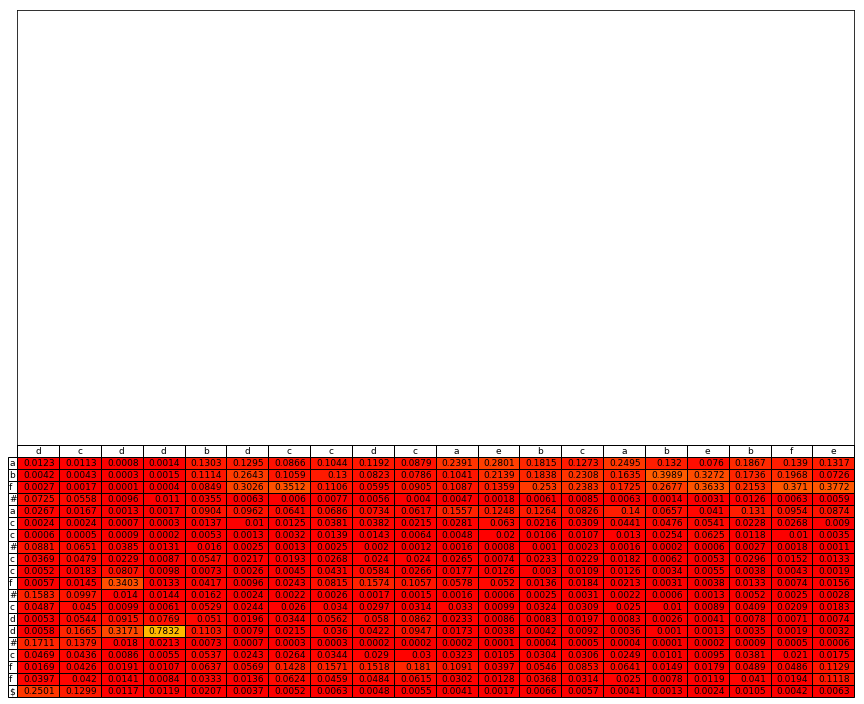

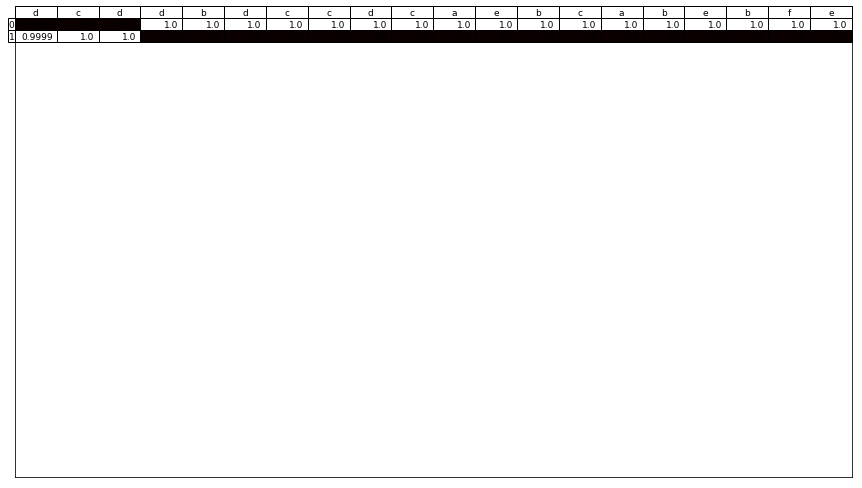

In [37]:
av = np.transpose(attn_vals)
idx = Index(list(ts[:20]))
df = DataFrame(av, index=idx, columns=list(ts[20:]))
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

tab1=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='bottom', 
                    cellColours=plt.cm.hot(normal(vals)))

idx = Index(["0", "1"])
df = DataFrame(np.transpose(prediction_at_step), index=idx, columns=list(ts[20:]))
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min(), vals.max())

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

tab2=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='top', 
                    cellColours=plt.cm.hot(normal(vals)))

## Analysis and Diagnostic Classifier

In [28]:
from sklearn import metrics
from scipy import stats
import scipy as sp

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from scipy.stats import pearsonr

import seaborn as sns

In [29]:
def hypothesis_k_factors(text):
    return np.array([-1 if x == '#' or x == '$' else 1 for x in text])

def hypothesis_detect_k_factors(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
    return hyp

def hypothesis_match_grammar(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
            for i, j in zip(range(len(kf)), reversed(range(len(kf)))):
                if j != 0:
                    ind = [m.start() for m in re.finditer(kf[:-j], text)]
                    print(ind, kf[:-j], i)
                    for el in ind:
                        hyp[el:el+i] = 1
    return hyp

In [67]:
hypothesis_match_grammar("bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb")

[8, 9, 12, 24, 28] c 0
[12, 28] cd 1


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

In [30]:
def validate_hypothesis(model, diag_classifier, hypothesis, train_len=50,
                        test_len=1, tt=None, save_hyp=None, save_diag=None, save_resp=None):
    # Generate hypothesis data
    def gen_hyp_data(model, N, hypothesis, start_index):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        inp, target = generate_random_batch(len_example, N, inps, labels)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(inp[i])):
                _, hidden, cell = rnn(inp[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(inps[i])
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(inps[i])
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)
    
    def gen_hyp_data_test(model, N, hypothesis, tt):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        tensor_tt = convert_string(tt)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(tensor_tt[i])):
                _, hidden, cell = rnn(tensor_tt[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(tt)
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(tt)
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)

    # Generate train and test data
    _, train_hyps, train_hiddens, train_hiddens_2 = gen_hyp_data(model, train_len, hypothesis, 0)
    test_texts, test_hyps, test_hiddens, test_hiddens_2 = gen_hyp_data_test(model, test_len, hypothesis, tt)
    #print(pearsonr(train_hiddens, train_hyps))
    #print(pearsonr(test_hiddens, test_hyps))

    # Train Diagnostic Classifier
    diag_classifier.fit(train_hiddens, train_hyps)
    
    # Predict with Diagnostic Classifier
    pred_hyps = diag_classifier.predict(test_hiddens)
    
    # Find responsible neuron
    resp_neuron = np.argmax(np.abs(diag_classifier.coef_))
    print(resp_neuron)
    
    # Plot results
    if save_hyp:
        plot_colored_text(test_texts[:len_example], test_hyps[:len_example],
                          title='Formed Hypothesis',
                          save_file=save_hyp)
    if save_diag:
        plot_colored_text(test_texts[:len_example], pred_hyps[:len_example],
                          title='Diagnostic Classifier Prediction',
                          save_file=save_diag)
    if save_resp:
        plot_colored_text(test_texts[:len_example], test_hiddens[:len_example, resp_neuron],
                          title='Most Responsible Neuron {}'.format(resp_neuron),
                          save_file=save_resp)
        
    del(train_hyps)
    del(train_hiddens)
    del(test_texts)
    del(test_hiddens)
    gc.collect()
    
    return test_hyps, pred_hyps

In [31]:
### PLOTTING HELPERS ###
def wrap_colored_text(text, colors, W, tabsize=4):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []

    # Wrap lines to width
    for char, color in zip(text, colors):
        if char == '\t':
            for i in range(tabsize):
                new_text.append(' ')
                new_colors.append(color)
        else:
            new_text.append(char)
            new_colors.append(color)
            if char == '\n':
                for i in range(W - len(new_text) % W):
                    new_text.append(' ')
                    new_colors.append(np.zeros_like(colors[0]))

    # Add final space to obtain (rectangular) matrix
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))

    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

def plot_colored_text(text, colors, W=80, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_text(text, colors, W, tabsize=4)

    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))

    color_palette = sns.color_palette("RdBu_r", 255, desat=.9)
    color_palette[127] = (1.,1.,1.) # set zero to white color
    sns.heatmap(wrapped_colors, annot=wrapped_text,
                annot_kws={'color':'black',
                           'family':'monospace',
                           'horizontalalignment':'center',
                           'fontweight':'light'},
                fmt='s', cbar=False, vmin=-2, vmax=2)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [32]:
model_name = "lstm_2000example_20000c_attn"
hyp_name = "detect_k_factors"
y_true, y_pred = validate_hypothesis(rnn, LogisticRegression(), hypothesis_detect_k_factors,
                                         train_len=1000, test_len=1, tt="bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb",
                                         save_hyp='plots/{}_hyp_{}.png'.format(model_name, hyp_name),
                                         save_diag='plots/{}_diag_{}.png'.format(model_name, hyp_name),
                                         save_resp='plots/{}_resp_{}.png'.format(model_name, hyp_name))

ValueError: not enough values to unpack (expected 2, got 0)

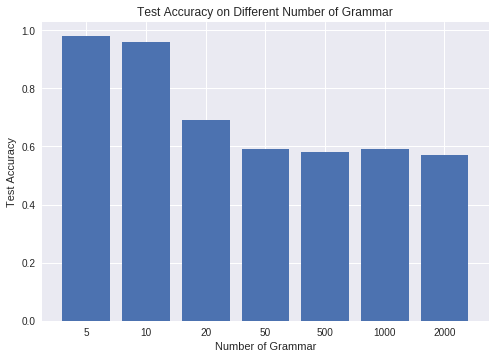

In [114]:
acc_test = [0.98, 0.96, 0.69, 0.59, 0.58, 0.59, 0.57]
experiment = [5, 10, 20, 50, 500, 1000, 2000]
x = np.arange(len(acc_test))
plt.bar(x, acc_test)
plt.xticks(x, experiment)
plt.xlabel('Number of Grammar')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy on Different Number of Grammar')
plt.savefig("plots/lstm_test_acc_bar.png")
plt.show()